## **Classez des images**

### partie 1/4 : analyse et prétraitement des images

<br>

> #### notebook contenant l'analyse et le prétraitement d'images (e.g. whitening, equalization, modification de la taille des images). <br><br>

<br>


## 0 Imports


### 0.1 Librairies, réglages


In [1]:
# paths, folders/files
import os, sys, random
from glob import glob
import re
# from zipfile import ZipFile

# math, dataframes
import numpy as np
import pandas as pd
from pandarallel import pandarallel
# from collections import Counter

# Visualisation
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.image import imread
# import seaborn as sns
import plotly.express as px
# from wordcloud import WordCloud
from PIL import Image, ImageOps #, ImageEnhance

# Feature engineering
from sklearn import preprocessing
try:
    import cv2
except:
    print('Installing opencv...')
    !pip install opencv-python # activate env first


print('\nPython version ' + sys.version)
print('pandas version ' + pd.__version__)

# plt.style.use('ggplot')
pd.set_option('display.max_rows', 200)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)



Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
pandas version 2.2.1

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 0.2 Fonctions


In [2]:
#


### 0.3 Variables globales


In [3]:
nb_classes = 3      # min 2, max 120


## 1 Data, analyse


### 1.1 Observons nos données


In [4]:
# Nous avons besoin d'un dataframe contenant :

# - 1 feature : les photos (ou leurs adresses) pour les classes qui nous intéressent
#               (3 classes pour commencer)
# - la target (= la race du chien pour chaque photo)


# verify path

def check_folders(path='./data/raw_data/Images'):
    """List content of the Image folder"""
    data_path = glob(path+'*/*')
    list_folders = [folder for folder in data_path]
    print(len(list_folders), '\n')

    pprint(list_folders)


check_folders()


120 

['./data/raw_data/Images/n02108551-Tibetan_mastiff',
 './data/raw_data/Images/n02088466-bloodhound',
 './data/raw_data/Images/n02088094-Afghan_hound',
 './data/raw_data/Images/n02094114-Norfolk_terrier',
 './data/raw_data/Images/n02105505-komondor',
 './data/raw_data/Images/n02098286-West_Highland_white_terrier',
 './data/raw_data/Images/n02095889-Sealyham_terrier',
 './data/raw_data/Images/n02108000-EntleBucher',
 './data/raw_data/Images/n02113624-toy_poodle',
 './data/raw_data/Images/n02099429-curly-coated_retriever',
 './data/raw_data/Images/n02089973-English_foxhound',
 './data/raw_data/Images/n02099712-Labrador_retriever',
 './data/raw_data/Images/n02099601-golden_retriever',
 './data/raw_data/Images/n02110063-malamute',
 './data/raw_data/Images/n02108089-boxer',
 './data/raw_data/Images/n02100583-vizsla',
 './data/raw_data/Images/n02111500-Great_Pyrenees',
 './data/raw_data/Images/n02110958-pug',
 './data/raw_data/Images/n02100236-German_short-haired_pointer',
 './data/raw_

### 1.2 Représentation des classes


In [5]:
# We want to select 3 classes (breeds)
# Conseil mentor : choisir les 3 classes les mieux représentées
# (=contenant le + de photos) pour mieux entrainer les modèles ensuite.

# Observons combien de photos nous avons pour chaque dossier (race de chien)

def check_nb_pics(path='./data/raw_data/Images', n=nb_classes):
    """Count number of available pictures for each breed"""
    data_path = glob(path+'*/*')
    list_folders = [folder for folder in data_path]
    dict_nb_pics_per_breed = {}
    for folder in list_folders:
        path_pictures = glob(folder + '*/*.jp*')
        nb_pics = len([file for file in path_pictures])
        dict_nb_pics_per_breed[folder] = nb_pics

    return dict_nb_pics_per_breed

dict_nb_pics = check_nb_pics()


In [6]:
# sort the dict in descending order
dict_nb_pics = dict(sorted(dict_nb_pics.items(), key=lambda item: item[1], reverse=True))


In [7]:
# Visualisons
df_nb_pics = pd.DataFrame(list(dict_nb_pics.items()), columns=['breed', 'nb_pics'])

# Sort the DataFrame in descending order
df_nb_pics = df_nb_pics.sort_values(by='nb_pics', ascending=False)

print(df_nb_pics.shape)
df_nb_pics.describe()

# Le describe(), c'est déjà une visualisation :)


(120, 2)


nb_pics
count  120.000000
mean   171.500000
std     23.220898
min    148.000000
25%    152.750000
50%    159.500000
75%    186.250000
max    252.000000

In [8]:
# Plot the distribution using Plotly
fig = px.bar(df_nb_pics, x='breed', y='nb_pics', labels={'breed': 'breed', 'nb_pics': 'nb_pics'},
             title='How many pictures for each breed', text='nb_pics')
fig.update_xaxes(tickangle=90, tickmode='array', tickvals=df_nb_pics.index, ticktext=df_nb_pics['breed'])

# Show the plot
fig.show()


### 1.3 Petite regex pour extraire les noms depuis l'adresse du dossier


In [9]:
# Ici l'interactivité de plotly est vraiment pratique
# mais les noms contenant l'adresse du fichier restent difficiles à lire,
# nettoyons avec une regex

def address_into_breed(address, lower=False):
    """Exctract breed name from address, return it (lowered, optional)"""
    # Define the regex pattern to extract the breed name
    pattern = r'-([^-]+)$'

    # Search for the pattern in the input string
    match = re.search(pattern, address)

    # Extract the breed name if a match is found
    if match:
        breed_name = match.group(1)
    else:
        breed_name = address

    if lower:
        return breed_name.lower() # + simple, mais...
    else:
        return breed_name # ...utilisable pour naviguer ds ls dossiers


df_nb_pics['breed'] = df_nb_pics['breed'].apply(address_into_breed)

display(df_nb_pics.head(120))

# nickel


breed  nb_pics
0                       Maltese_dog      252
1                      Afghan_hound      239
2                Scottish_deerhound      232
3                        Pomeranian      219
4                           Samoyed      218
5              Bernese_mountain_dog      218
6                   Irish_wolfhound      218
7                               Tzu      214
8                    Great_Pyrenees      213
9                          Leonberg      210
10                          basenji      209
11                  Tibetan_terrier      206
12                 Sealyham_terrier      202
13                      EntleBucher      202
14                         Airedale      202
16                           Saluki      200
15                              pug      200
18                            cairn      197
17                 Lakeland_terrier      197
19                         papillon      196
20               Australian_terrier      196
21                             chow      196
22               Norwegian_elkhound      196
23                     Newfoundland      195
24                           beagle      195
25                   Siberian_husky      192
26                 Blenheim_spaniel      188
27                     Ibizan_hound      188
28                       bloodhound      187
29                          whippet      187
30                            Lhasa      186
32                 Japanese_spaniel      185
31                  Norwich_terrier      185
33               miniature_pinscher      184
34                    silky_terrier      183
35                Italian_greyhound      182
36                      Boston_bull      182
37               Bedlington_terrier      182
38                         Pembroke      181
39                   Dandie_Dinmont      180
40               Kerry_blue_terrier      179
41                         malamute      178
42                           basset      175
43                  Norfolk_terrier      172
44              Rhodesian_ridgeback      172
45                      toy_terrier      172
46                   Border_terrier      172
48                         bluetick      171
47               Labrador_retriever      171
49                    Saint_Bernard      170
50      West_Highland_white_terrier      169
51                    Irish_terrier      169
52             Old_English_sheepdog      169
53              African_hunting_dog      169
54       Greater_Swiss_Mountain_dog      168
55         Chesapeake_Bay_retriever      167
56                Yorkshire_terrier      164
57   American_Staffordshire_terrier      164
58                   English_setter      161
59                       Weimaraner      160
63                    tan_coonhound      159
64                   cocker_spaniel      159
60                  standard_poodle      159
62                 English_springer      159
61                   French_bulldog      159
65                         keeshond      158
66                   Scotch_terrier      158
67                 English_foxhound      157
68                  giant_schnauzer      157
69               haired_fox_terrier      157
70                Shetland_sheepdog      157
71                            dingo      156
72                       Great_Dane      156
73                     bull_mastiff      156
74           coated_wheaten_terrier      156
79                 Mexican_hairless      155
80                     Irish_setter      155
78                         Cardigan      155
77               standard_schnauzer      155
76        Staffordshire_bullterrier      155
75                 miniature_poodle      155
81                         komondor      154
82                           vizsla      154
83                       schipperke      154
84              miniature_schnauzer      154
85                     Walker_hound      153
86                Brabancon_griffon      153
87                    Gordon_setter      153
88                       

### 1.4 Top 3 classes


In [10]:
# Plot the distribution again
fig = px.bar(df_nb_pics, x='breed', y='nb_pics', labels={'breed': 'breed', 'nb_pics': 'nb_pics'},
             title='How many pictures for each breed', text='nb_pics')
fig.update_xaxes(tickangle=90, tickmode='array', tickvals=df_nb_pics.index, ticktext=df_nb_pics['breed'],
                 tickfont=dict(size=12)) # zoom in

fig.show()

# et nos 3 gagnants sont :
selected_breeds = ['Maltese_dog', 'Afghan_hound', 'Scottish_deerhound']

# On peut les récupérer automatiquement, depuis notre dict ou df.
breeds = list(dict_nb_pics)[:nb_classes]

# Pour l'instant on va garder l'adresse, + pratique pour l'étape suivante
# selected_breeds = [address_into_breed(x) for x in breeds]
selected_breeds = [x for x in breeds]
print(selected_breeds)


['./data/raw_data/Images/n02085936-Maltese_dog', './data/raw_data/Images/n02088094-Afghan_hound', './data/raw_data/Images/n02092002-Scottish_deerhound']


### 1.5 Vérification que les données sont complètes


In [11]:
# Au fait, est-ce qu'on est sûr d'avoir bien récupéré ttes les photos ?
# Si certaines sont en .png par exemple, notre fonction ne les importe pas.
# Les photos semblent être ttes en .jpg, mais je n'ai pqs vérifié manuellement ts les dossiers.

def check_nb_files(path='./data/raw_data/Images', n=nb_classes):
    """Count all files present in each dog breed folder, to verify we didn't miss any picture.
    Return dictionary {folder: nb files}"""
    data_path = glob(path+'*/*')
    list_folders = [folder for folder in data_path]
    dict_nb_files_per_breed = {}
    for folder in list_folders:
        path_pictures = glob(folder + '*/*.*')
        nb_files = len([file for file in path_pictures])
        dict_nb_files_per_breed[folder] = nb_files

    return dict_nb_files_per_breed


dict_nb_files = check_nb_files()

# sort the dict in descending order
dict_nb_files = dict(sorted(dict_nb_files.items(), key=lambda item: item[1], reverse=True))

# Visualisons
df_nb_files = pd.DataFrame(list(dict_nb_files.items()), columns=['breed', 'nb_files'])
display(df_nb_files.describe())

# (rappel)
df_nb_pics.describe()

# identiques, ok


nb_files
count  120.000000
mean   171.500000
std     23.220898
min    148.000000
25%    152.750000
50%    159.500000
75%    186.250000
max    252.000000

nb_pics
count  120.000000
mean   171.500000
std     23.220898
min    148.000000
25%    152.750000
50%    159.500000
75%    186.250000
max    252.000000

### 1.6 Création du dataframe


In [12]:
# create df

data = pd.DataFrame()

for breed in selected_breeds:
    print(breed)
    path = f'{breed}'
    data_path = glob(path+'*/*.*')

    folder_data = pd.DataFrame()
    list_pictures = [file for file in data_path]
    pprint(list_pictures)

    folder_data['photo_path'] = list_pictures
    folder_data['breed'] = address_into_breed(breed, lower=True) # + propre
    data = pd.concat([data, folder_data], ignore_index=True)



./data/raw_data/Images/n02085936-Maltese_dog
['./data/raw_data/Images/n02085936-Maltese_dog/n02085936_4262.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_10610.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_4004.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_500.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_10199.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_4257.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_5068.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_6464.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_5545.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_8616.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_7465.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_9742.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_2832.jpg',
 './data/raw_data/Images/n02085936-Maltese_dog/n02085936_5103.jpg',
 '

In [13]:
display(data.head())
data.tail()


photo_path        breed
0  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog
1  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog
2  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog
3  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog
4  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog

photo_path               breed
718  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound
719  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound
720  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound
721  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound
722  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound

In [14]:
data.groupby("breed").count()


photo_path
breed                         
afghan_hound               239
maltese_dog                252
scottish_deerhound         232

### 1.7 Encodage des cibles


In [15]:
# encodage target

le = preprocessing.LabelEncoder()
le.fit(data["breed"])

data["target"] = le.transform(data["breed"])

display(data.head())
data.tail()


photo_path        breed  target
0  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1
1  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1
2  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1
3  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1
4  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1

photo_path               breed  \
718  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound   
719  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound   
720  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound   
721  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound   
722  ./data/raw_data/Images/n02092002-Scottish_deer...  scottish_deerhound   

     target  
718       2  
719       2  
720       2  
721       2  
722       2

### 1.8 Affichage de qq photos pour chaque classe


photo_path
0  ./data/raw_data/Images/n02088094-Afghan_hound/...

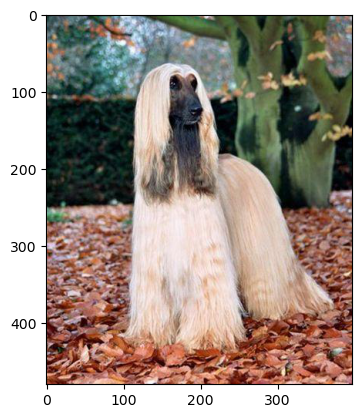

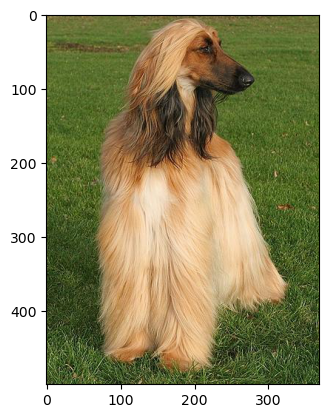

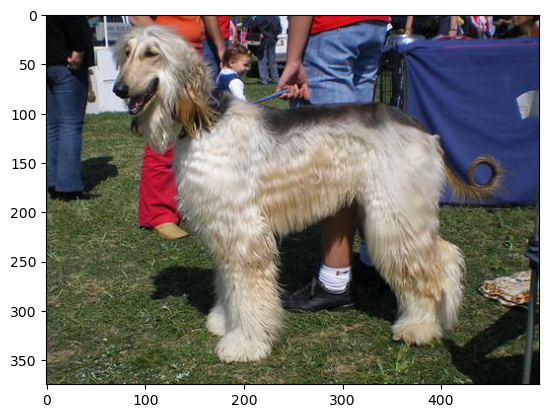

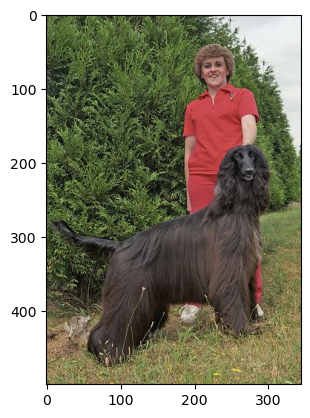

photo_path
0  ./data/raw_data/Images/n02085936-Maltese_dog/n...

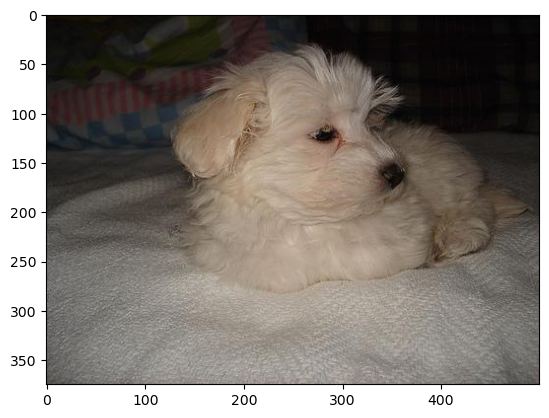

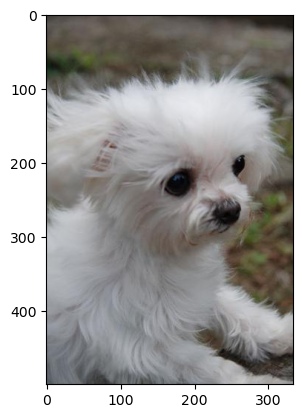

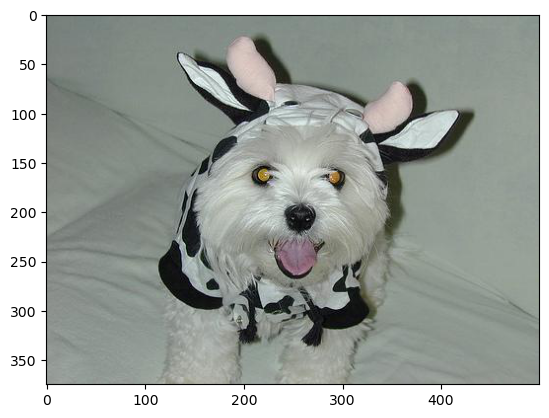

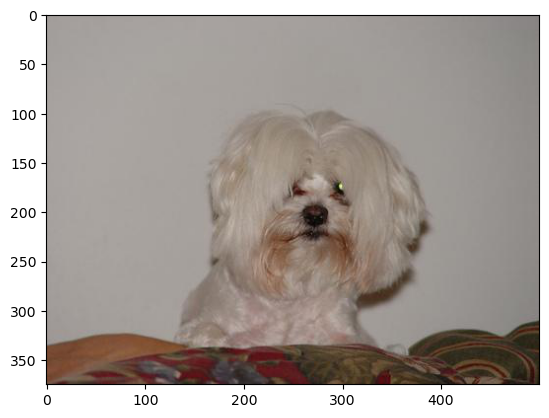

photo_path
0  ./data/raw_data/Images/n02092002-Scottish_deer...

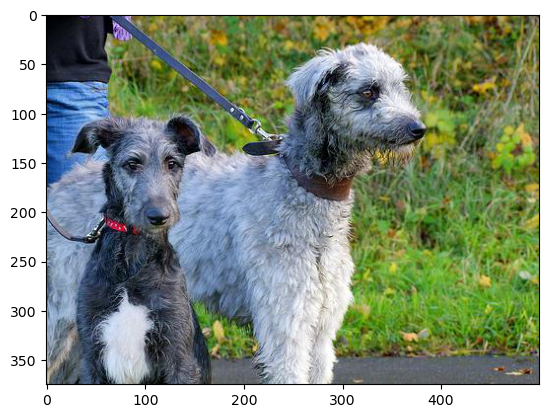

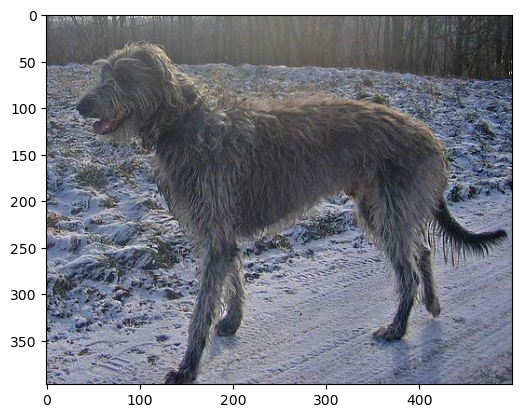

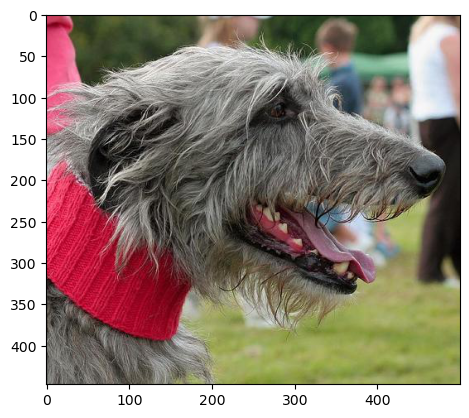

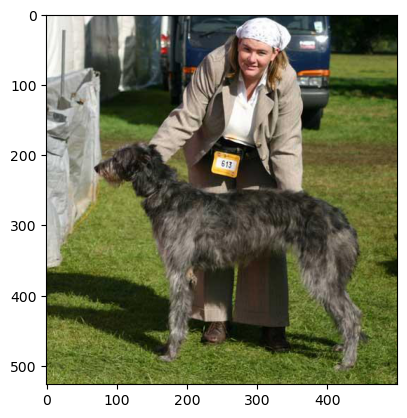

In [16]:
# show a few random pictures (4) for each breed

for i in range(nb_classes):
    subset = data.loc[data['target'] == i, ['photo_path']]
    # Shuffle the subset
    shuffled_subset = subset.sample(n=4).reset_index(drop=True)
    display(shuffled_subset.head(1))

    for j in range(shuffled_subset.shape[0]):
        image = imread(shuffled_subset['photo_path'][j])
        plt.imshow(image)
        plt.show()


### 1.9 Taille des images


In [17]:
# Ajouter infos pour .describe() : largeur, hauteur
# Ces métadonnées sont présentes dans le dossier Annotation, mais autant vérifier directement.

def get_width(address):
    """Return a picture's width (from its address)"""
    img = Image.open(address)
    width, height = img.size
    return width

def get_height(address):
    """Return a picture's height (from its address)"""
    img = Image.open(address)
    width, height = img.size
    return height

data['width'] = data['photo_path'].apply(get_width)
data['height'] = data['photo_path'].apply(get_height)

data.head()


photo_path        breed  target  \
0  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
1  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
2  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
3  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
4  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   

   width  height  
0    500     333  
1    500     375  
2    400     500  
3    500     333  
4    500     375

In [18]:
data[['width', 'height']].describe()


width       height
count   723.000000   723.000000
mean    448.680498   415.004149
std     110.799319    95.457471
min     193.000000   180.000000
25%     375.000000   343.500000
50%     500.000000   375.000000
75%     500.000000   500.000000
max    1448.000000  1208.000000

In [19]:
# check pixel values ? (pour une éventuelle normalisation)
# 0-255 pour .jpg


## 2 Prétraitement


In [20]:
# Dépend du modèle


# Concerne seulement notre modèle perso (ntbk 2),
# les modèles importés pour le transfer learning (ntbk 3) ont leur propre preprocessing
# (fonction preprocess_input())

# models possible -> "inspiration" :
# vérifier licenses. Apache 2.0, GPL, MIT, CC... ?

# "historique" : AlexNet
# le + simple, five convolutional layers, followed by three fully connected layers

# vgg16 et 19
# restent assez simples (/nb de layers, mais entre guillemets car le cours précise qu'ils faut déjà
# + d'un mois pour les entrainer)

# GoogLeNet, also known as Inception v1 : 22 layers
# "introduced the Inception module, which allows the network to learn features at multiple scales.
# The Inception module consists of parallel convolutional layers with different filter sizes,
# which are concatenated to form the output of the module. GoogLeNet also introduced the use of
# global average pooling, which reduces the number of parameters in the network and helps
# prevent overfitting. " (https://jonascleveland.com/best-image-classification-models/)


# ensuite on passe à 55 couches (MobileNet), puis 81 (Xception) et + !
# (jusqu'à 533 pour NASNetLarge)

# Parmi ces modèles + profond : tester un ResNet (microsoft), DenseNet (facebook)

# OC : "tels que par exemple VGG16, ResNet50, Inception V3 ou Inception ResNetV2"


# envie de tester en + ds quelle mesure la couleur "aide" les modèles,
# en modifiant preprocessing(-> black & white) + 1ere layer ?
# puis comparer scores


### 2.1 Taille


In [21]:
# AlexNet : 227×227 pixels
# VGG16 : 256x256
# VGG19 : 224x224
# Nos + petites photos : largeur min 193, hauteur min 180

# Define the target size for resizing
target_size = (100, 100)  # Example target size, adjust as needed

# Path to the directory containing the images
# in df
# image_dir = "./data/raw_images/"

# Path to save the resized images
output_dir = "./data/resized/"
os.makedirs(output_dir, exist_ok=True)


def resize_pic(address, target_size=target_size):
    """Resize a picture, save the result, return result's path (input param : address)"""
    image = cv2.imread(address)

    # Resize the image
    resized_image = cv2.resize(image, target_size)

    # Save the resized image
    output_path = os.path.join(output_dir, address_into_breed(address))
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, resized_image)

    return output_path


data['resized'] = data['photo_path'].apply(resize_pic)



In [22]:
data.head()


photo_path        breed  target  \
0  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
1  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
2  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
3  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
4  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   

   width  height                                         resized  
0    500     333   ./data/resized/Maltese_dog/n02085936_4262.jpg  
1    500     375  ./data/resized/Maltese_dog/n02085936_10610.jpg  
2    400     500   ./data/resized/Maltese_dog/n02085936_4004.jpg  
3    500     333    ./data/resized/Maltese_dog/n02085936_500.jpg  
4    500     375  ./data/resized/Maltese_dog/n02085936_10199.jpg

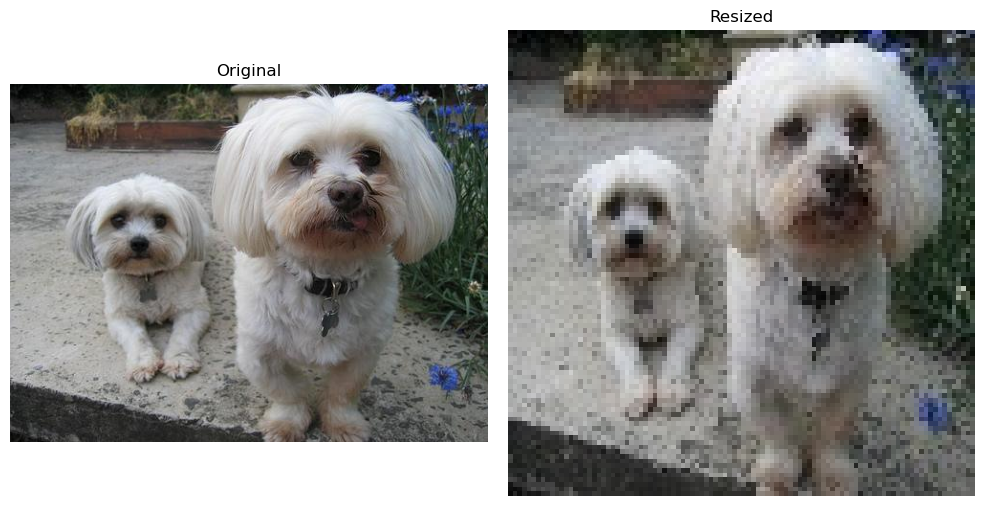

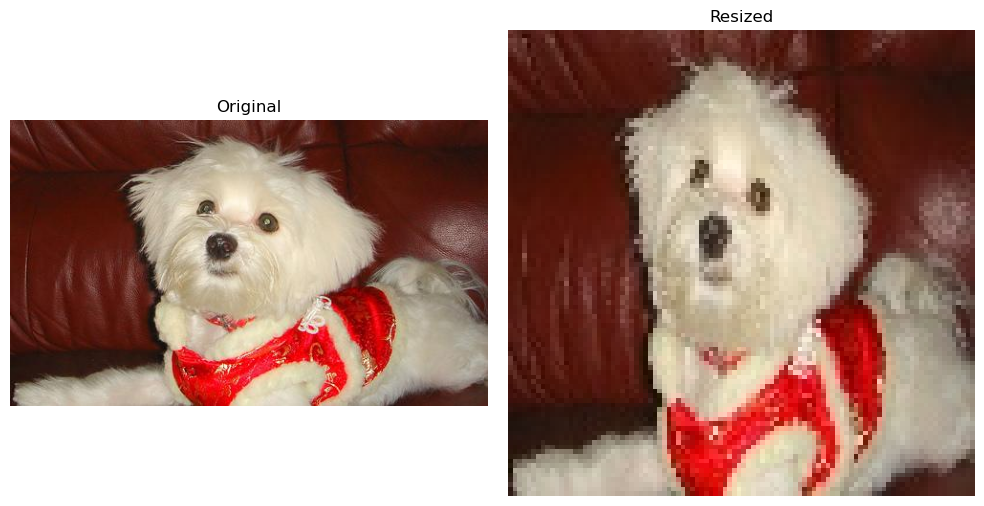

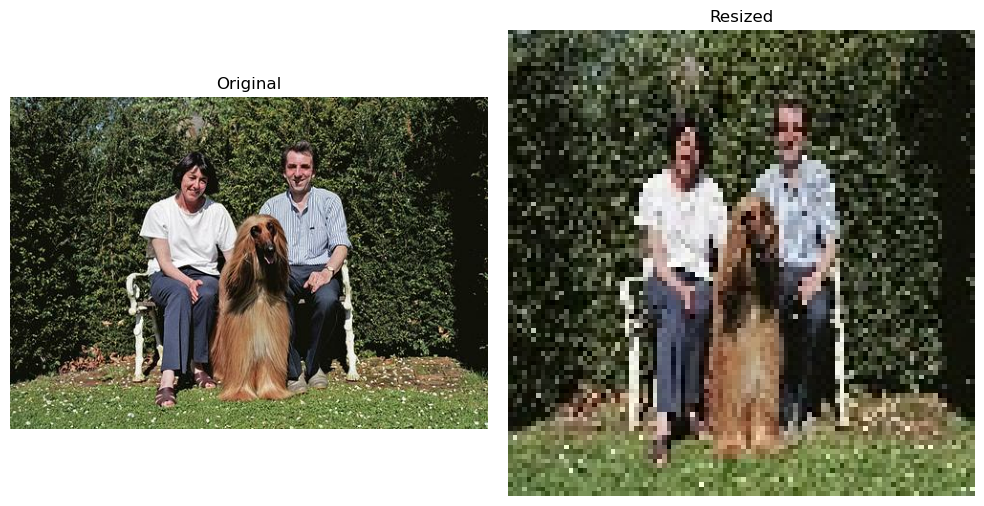

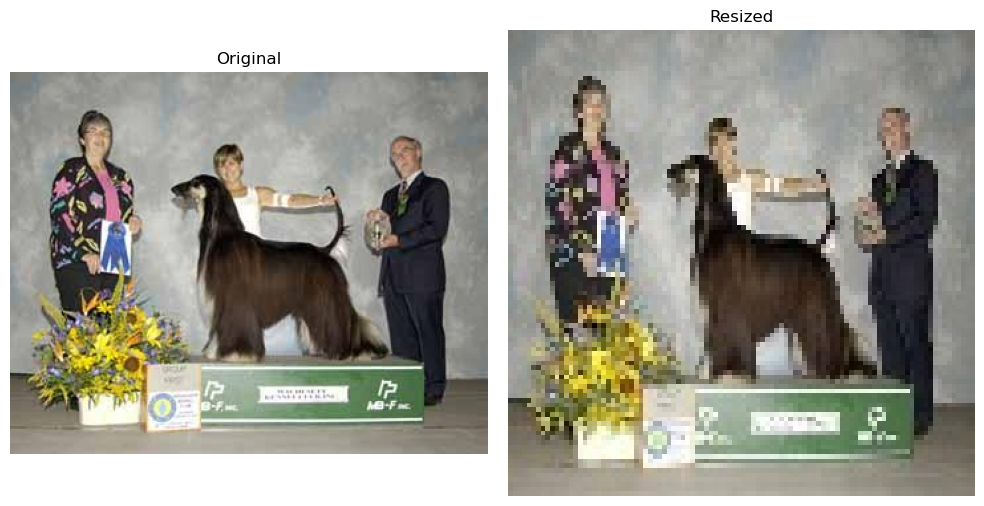

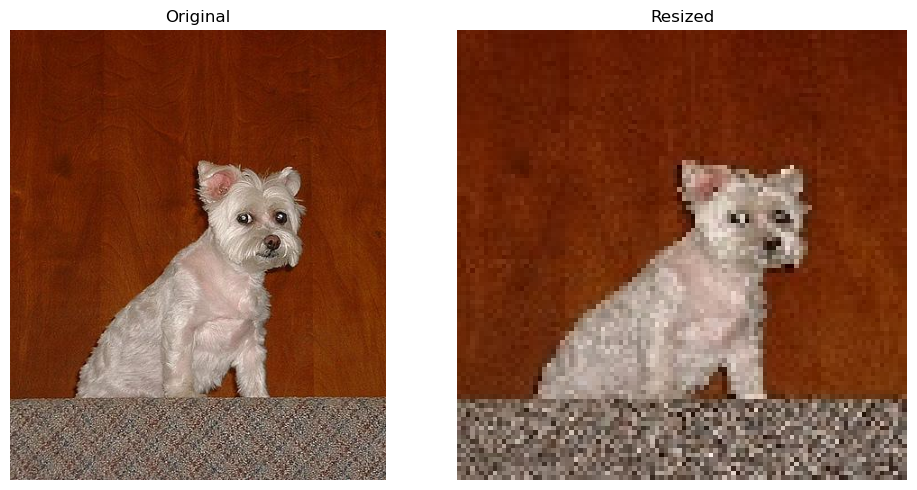

In [23]:
# Let's see the result

sample = data.sample(n=5).reset_index(drop=True)

for i in range(sample.shape[0]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Load and display original image
    axes[0].imshow(cv2.cvtColor(cv2.imread(sample['photo_path'][i]), cv2.COLOR_BGR2RGB))
    axes[0].axis('off')
    axes[0].set_title('Original')

    # Load and display image with corrected exposition
    axes[1].imshow(cv2.cvtColor(cv2.imread(sample['resized'][i]), cv2.COLOR_BGR2RGB))
    axes[1].axis('off')
    axes[1].set_title('Resized')

    plt.tight_layout()
    plt.show()

# ok, le redimensionnement peut déformer les images, mais il n'y a pas de crop (perte d'info)


### 2.2 Exposition


In [24]:
# We need a new regex

def new_address_into_breed(address, folder='resized'):
    """Extract folder name + file name for a given picture (address) and a given folder name
    (default: 'resized')"""
    # Define the regex pattern to extract the breed name
    pattern = r'{folder/(.+)$'

    # Search for the pattern in the input string
    match = re.search(pattern, address)

    # Extract the breed name if a match is found
    if match:
        breed_name = match.group(1)
    else:
        breed_name = address

    return breed_name.lower()


In [25]:
# syntaxe pillow + simple que cv2

# Path to save the corrected images
output_dir = "./data/expo/"
os.makedirs(output_dir, exist_ok=True)


def autocorrect_exposition(address):
    """On standardise l'exposition des photos, en utilisant la fonction .autoconstrast().
     Pour le contraste, il y a une fonction .autoexposition() ?? """
    # Read the image using PIL
    pil_img = Image.open(address)

    # Convert the image to RGB format (if it's not already)
    pil_img = pil_img.convert("RGB")

    # Apply autocontrast
    corrected_img = ImageOps.autocontrast(pil_img)

    # Save the corrected image
    output_path = os.path.join(output_dir, new_address_into_breed(address))
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    corrected_img.save(output_path)

    return output_path


data['expo'] = data['resized'].apply(autocorrect_exposition)


In [26]:
data.head()


photo_path        breed  target  \
0  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
1  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
2  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
3  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
4  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   

   width  height                                         resized  \
0    500     333   ./data/resized/Maltese_dog/n02085936_4262.jpg   
1    500     375  ./data/resized/Maltese_dog/n02085936_10610.jpg   
2    400     500   ./data/resized/Maltese_dog/n02085936_4004.jpg   
3    500     333    ./data/resized/Maltese_dog/n02085936_500.jpg   
4    500     375  ./data/resized/Maltese_dog/n02085936_10199.jpg   

                                                expo  
0  ./data/expo/./data/resized/maltese_dog/n020859...  
1  ./data/expo/./data/resized/maltese_dog/n020859...  
2  ./data/expo/./data/resized/maltese_dog/n020859...  
3  ./data/expo/./data/resized/maltese_dog/n020859...  
4  ./data/expo/./data/resized/maltese_dog/n020859...

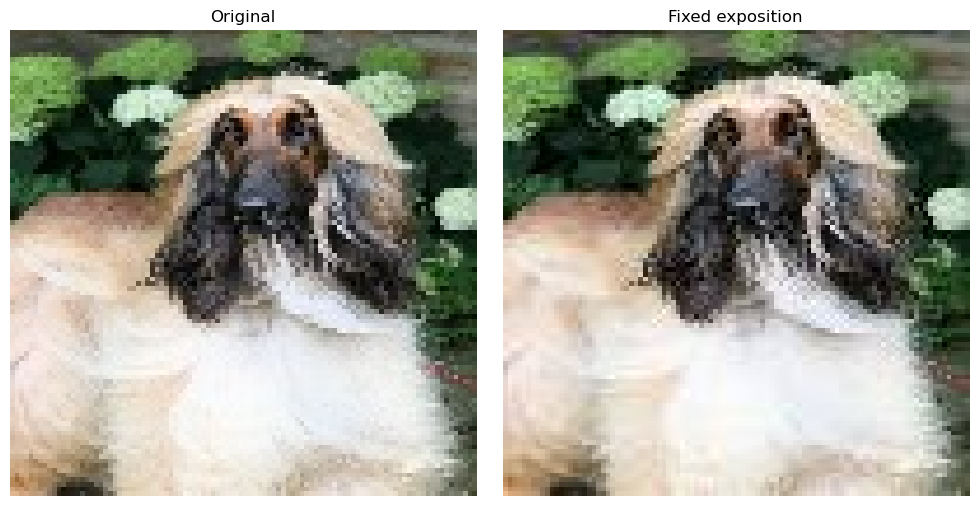

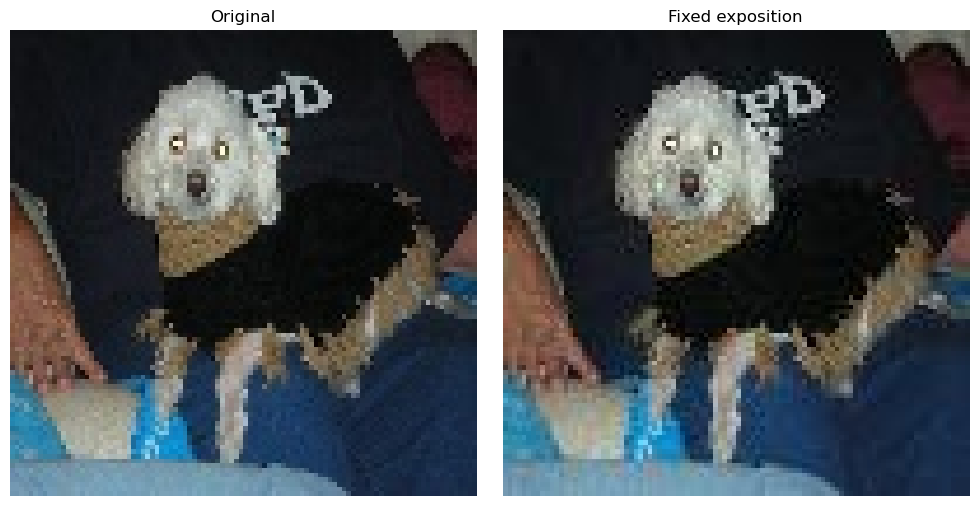

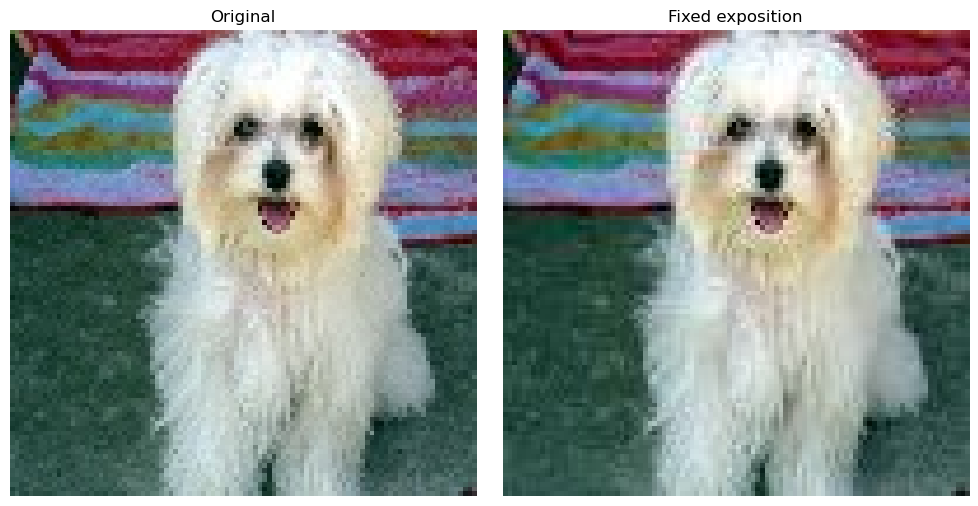

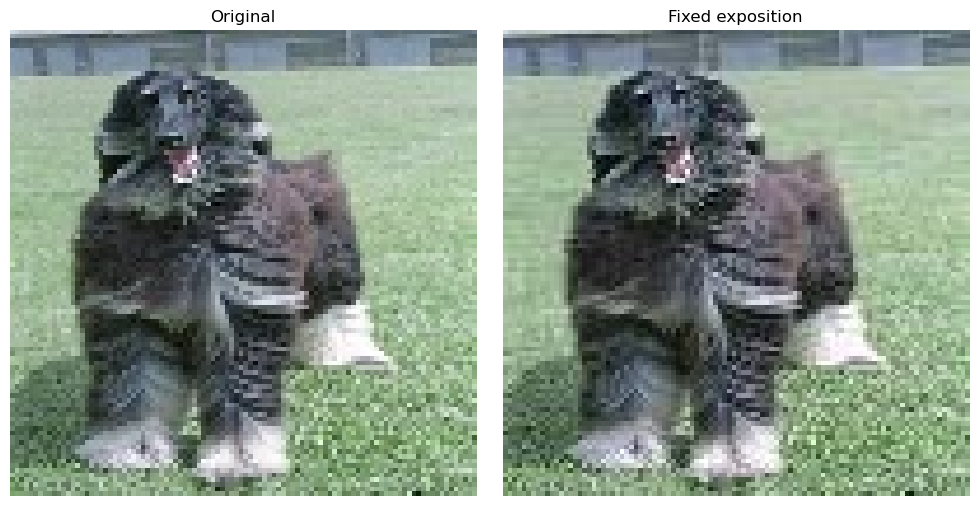

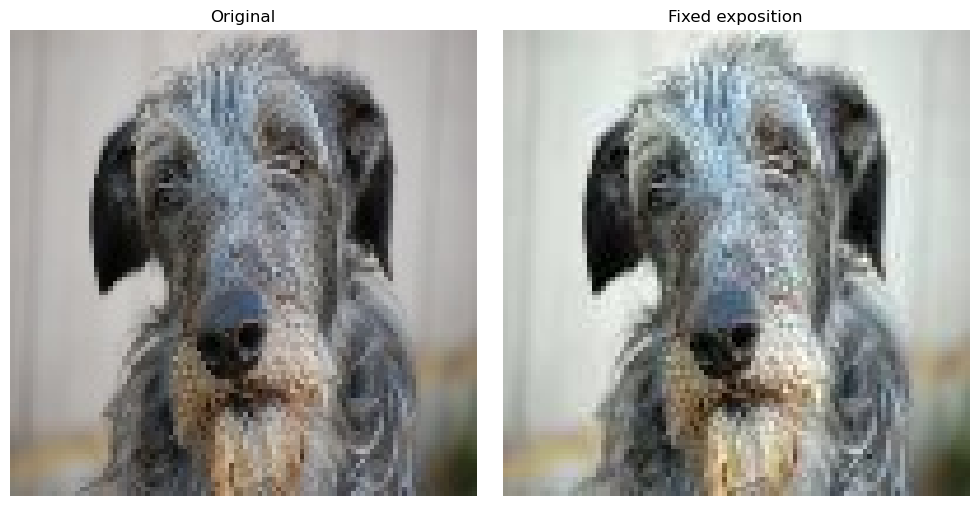

In [27]:
def before_after(before, after, title):
    """Pour visualiser facilement le résultats des opérations de prétraitement."""
    sample = data.sample(n=5).reset_index(drop=True)

    for i in range(sample.shape[0]):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Load and display original image
        axes[0].imshow(cv2.cvtColor(cv2.imread(sample[before][i]), cv2.COLOR_BGR2RGB))
        axes[0].axis('off')
        axes[0].set_title('Original')

        # Load and display image with corrected exposition
        axes[1].imshow(cv2.cvtColor(cv2.imread(sample[after][i]), cv2.COLOR_BGR2RGB))
        axes[1].axis('off')
        axes[1].set_title(title)

        plt.tight_layout()
        plt.show()


before_after('resized', 'expo', 'Fixed exposition')

# L'effet est moins évident, la plupart des photos ont déjà ss doute un système
# d'ajustement auto


### 2.3 Contraste


In [28]:
# Path to save the corrected images
output_dir = "./data/contraste/"
os.makedirs(output_dir, exist_ok=True)


def autocorrect_contraste(address):
    """Standardise le contraste. Semble saturer / désaturer certaines couleurs ?"""
    # Read the image using PIL
    pil_img = Image.open(address)

    # Convert the image to RGB format (if it's not already) (it is)
    pil_img = pil_img.convert("RGB")

    # Apply autocontrast
    corrected_img = ImageOps.equalize(pil_img)

    # Save the corrected image
    output_path = os.path.join(output_dir, new_address_into_breed(address, 'expo'))
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    corrected_img.save(output_path)

    return output_path


data['contraste'] = data['expo'].apply(autocorrect_contraste)


In [29]:
data.head()


photo_path        breed  target  \
0  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
1  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
2  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
3  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
4  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   

   width  height                                         resized  \
0    500     333   ./data/resized/Maltese_dog/n02085936_4262.jpg   
1    500     375  ./data/resized/Maltese_dog/n02085936_10610.jpg   
2    400     500   ./data/resized/Maltese_dog/n02085936_4004.jpg   
3    500     333    ./data/resized/Maltese_dog/n02085936_500.jpg   
4    500     375  ./data/resized/Maltese_dog/n02085936_10199.jpg   

                                                expo  \
0  ./data/expo/./data/resized/maltese_dog/n020859...   
1  ./data/expo/./data/resized/maltese_dog/n020859...   
2  ./data/expo/./data/resized/maltese_dog/n020859...   
3  ./data/expo/./data/resized/maltese_dog/n020859...   
4  ./data/expo/./data/resized/maltese_dog/n020859...   

                                           contraste  
0  ./data/contraste/./data/expo/./data/resized/ma...  
1  ./data/contraste/./data/expo/./data/resized/ma...  
2  ./data/contraste/./data/expo/./data/resized/ma...  
3  ./data/contraste/./data/expo/./data/resized/ma...  
4  ./data/contraste/./data/expo/./data/resized/ma...

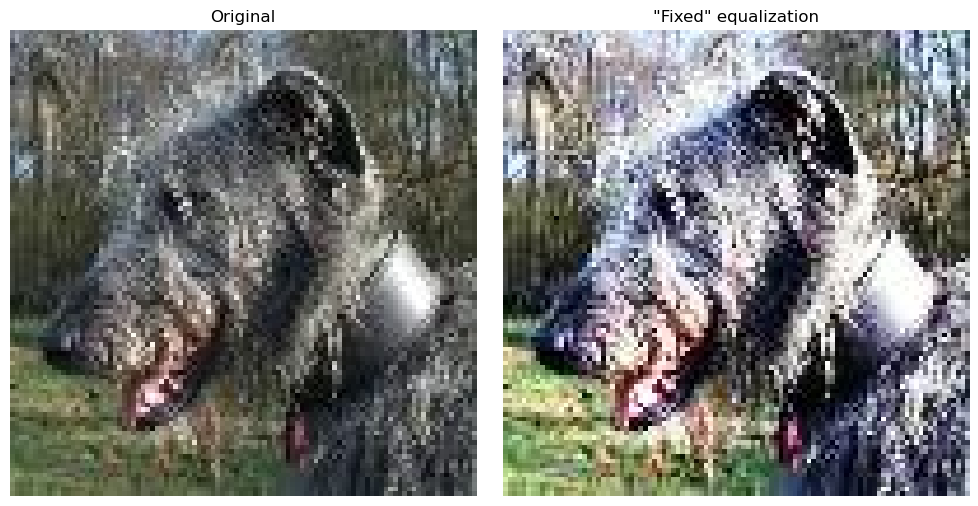

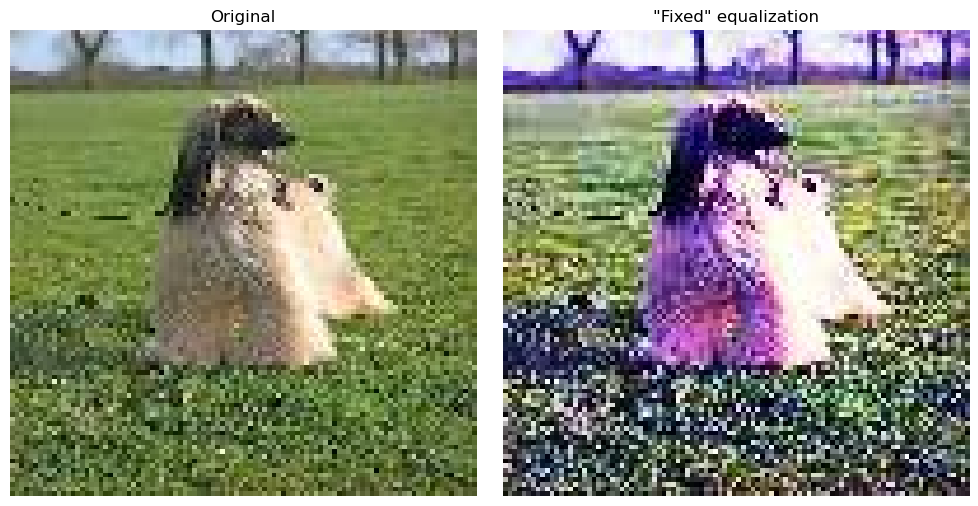

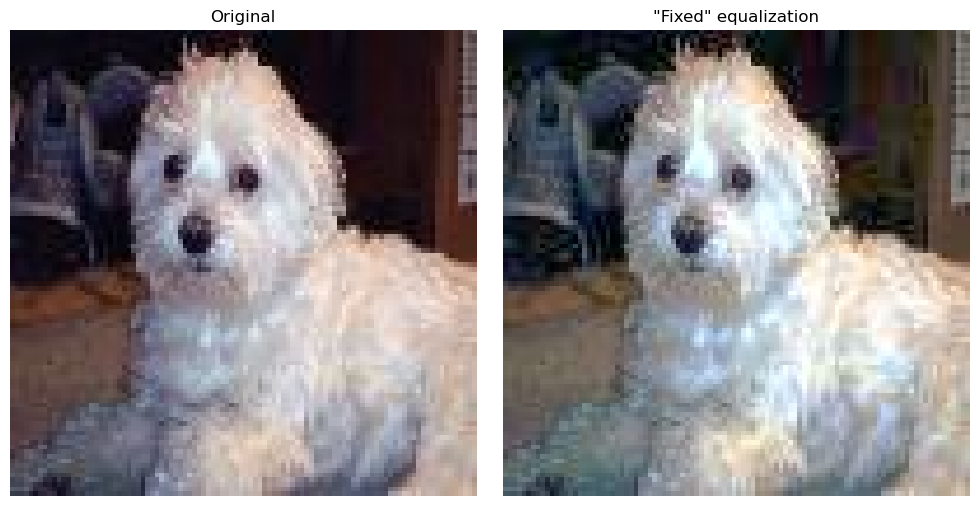

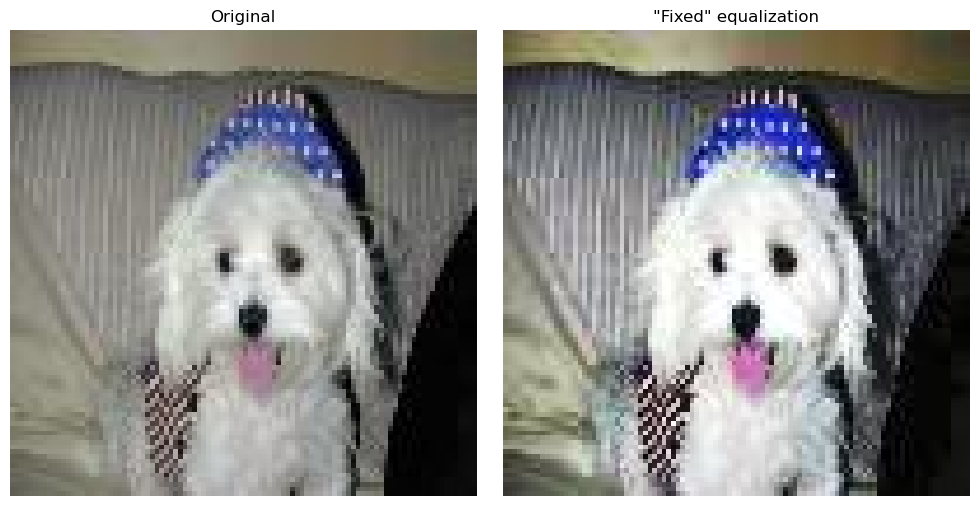

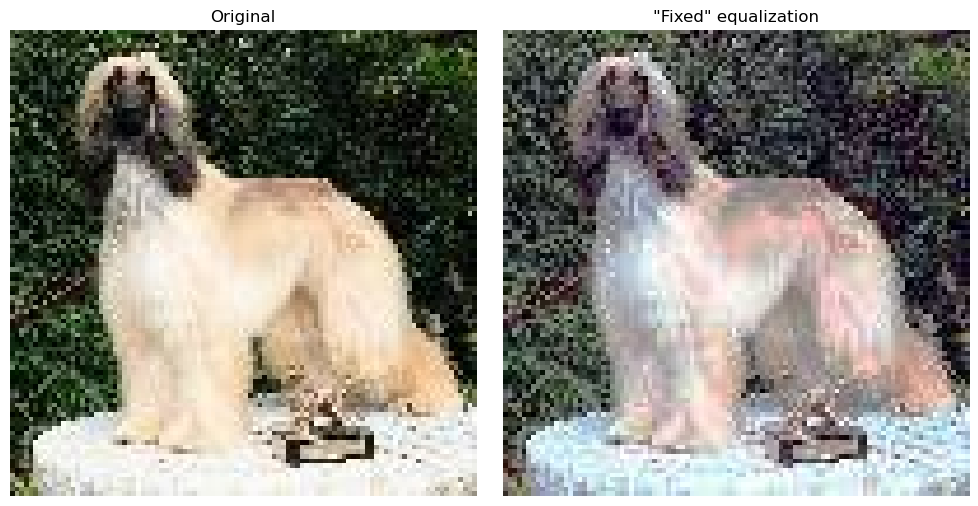

In [30]:
before_after('expo', 'contraste', '"Fixed" equalization')

# De mieux en mieux !


### 2.4 Bruit


In [31]:
# gaussien, pas remarqué de bruit "poivre et sel"

# Path to save the corrected images
output_dir = "./data/denoised/"
os.makedirs(output_dir, exist_ok=True)


def apply_gaussian_denoising(address):
    """🎶 Complètement flou. Mais qu'est-ce qui nous arrive ? 🎶"""
    # Read the image using OpenCV
    img = cv2.imread(address)

    # Apply Gaussian denoising
    denoised_img = cv2.GaussianBlur(img, (5, 5), 0)

    # Convert the denoised image to PIL format
    pil_img = Image.fromarray(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB))

    # Save the denoised image
    output_path = os.path.join(output_dir, new_address_into_breed(address, 'contraste'))
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    pil_img.save(output_path)

    return output_path


data['denoised'] = data['contraste'].apply(apply_gaussian_denoising)


In [32]:
data.head()


photo_path        breed  target  \
0  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
1  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
2  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
3  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   
4  ./data/raw_data/Images/n02085936-Maltese_dog/n...  maltese_dog       1   

   width  height                                         resized  \
0    500     333   ./data/resized/Maltese_dog/n02085936_4262.jpg   
1    500     375  ./data/resized/Maltese_dog/n02085936_10610.jpg   
2    400     500   ./data/resized/Maltese_dog/n02085936_4004.jpg   
3    500     333    ./data/resized/Maltese_dog/n02085936_500.jpg   
4    500     375  ./data/resized/Maltese_dog/n02085936_10199.jpg   

                                                expo  \
0  ./data/expo/./data/resized/maltese_dog/n020859...   
1  ./data/expo/./data/resized/maltese_dog/n020859...   
2  ./data/expo/./data/resized/maltese_dog/n020859...   
3  ./data/expo/./data/resized/maltese_dog/n020859...   
4  ./data/expo/./data/resized/maltese_dog/n020859...   

                                           contraste  \
0  ./data/contraste/./data/expo/./data/resized/ma...   
1  ./data/contraste/./data/expo/./data/resized/ma...   
2  ./data/contraste/./data/expo/./data/resized/ma...   
3  ./data/contraste/./data/expo/./data/resized/ma...   
4  ./data/contraste/./data/expo/./data/resized/ma...   

                                            denoised  
0  ./data/denoised/./data/contraste/./data/expo/....  
1  ./data/denoised/./data/contraste/./data/expo/....  
2  ./data/denoised/./data/contraste/./data/expo/....  
3  ./data/denoised/./data/contraste/./data/expo/....  
4  ./data/denoised/./data/contraste/./data/expo/....

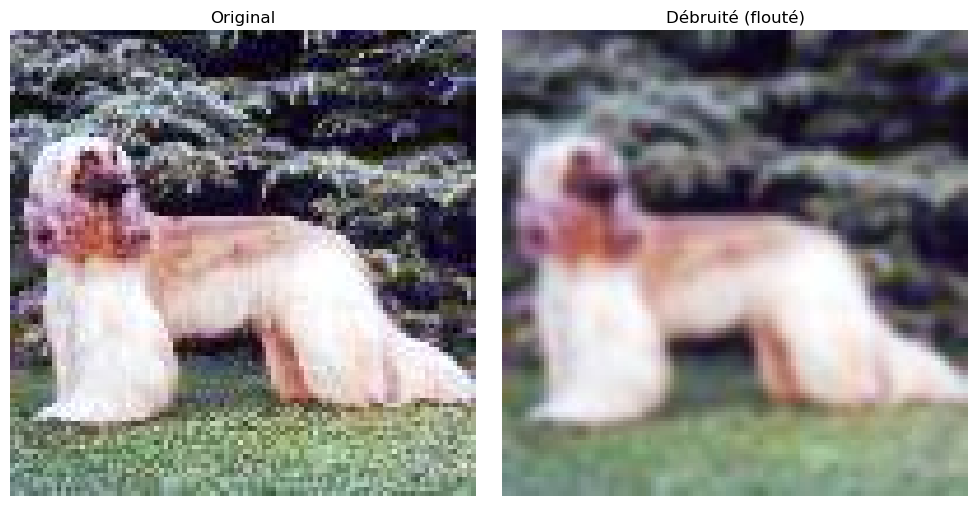

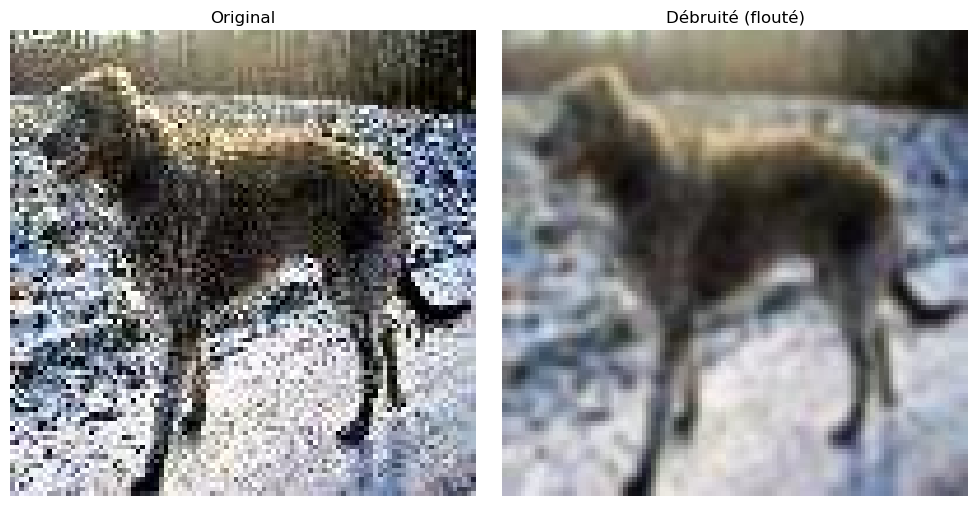

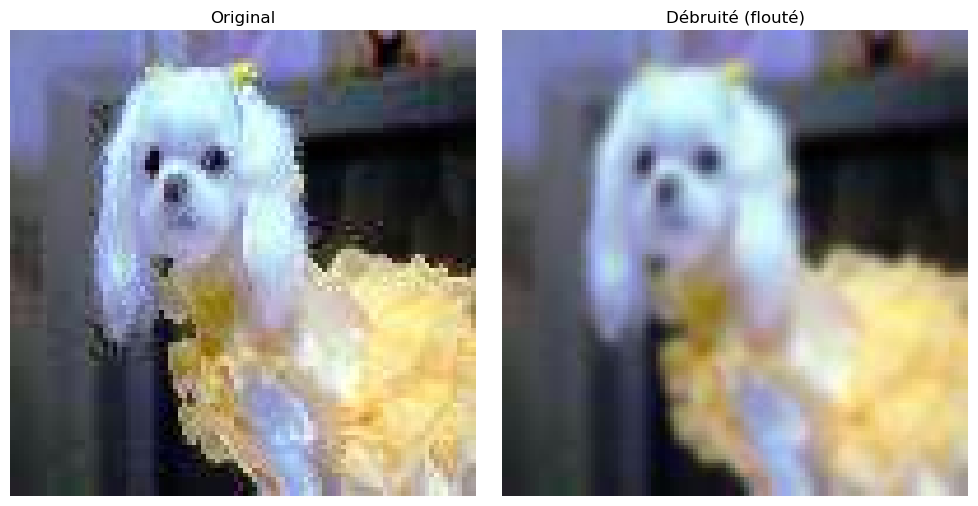

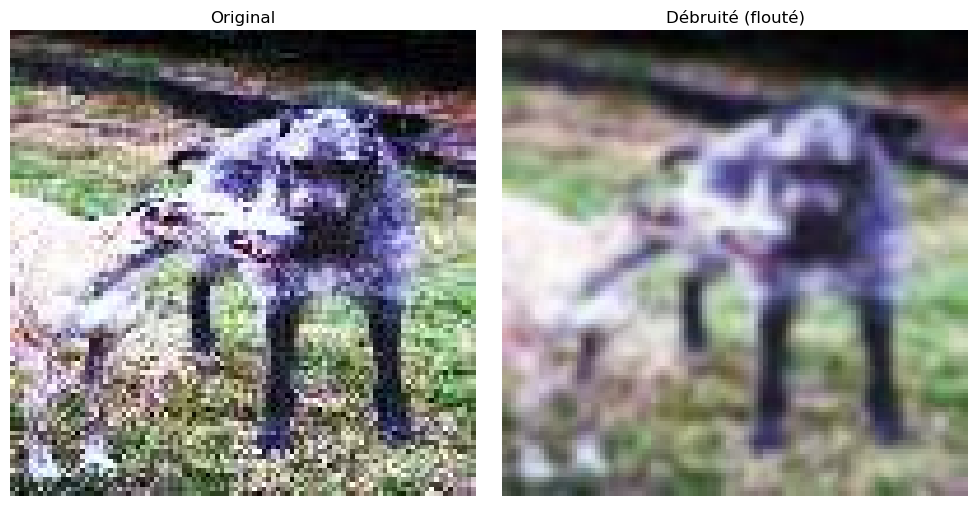

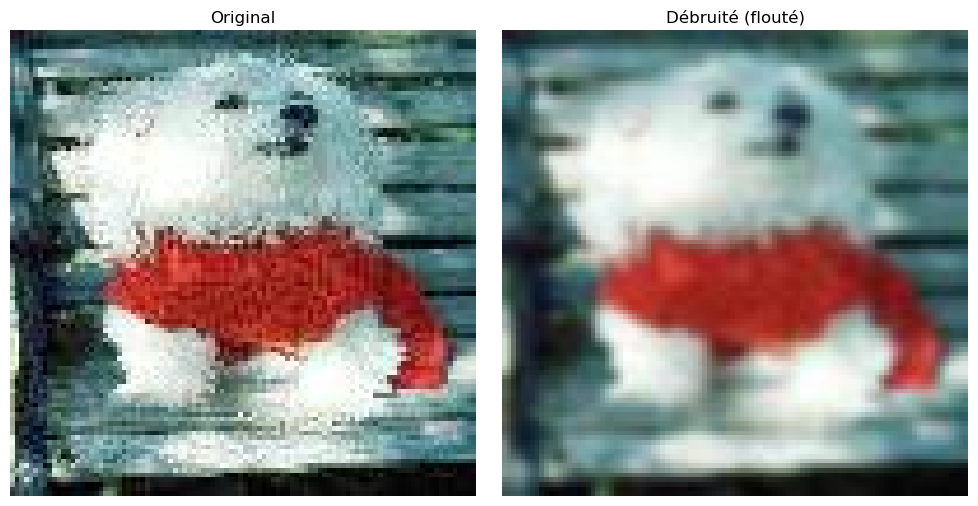

In [33]:
before_after('contraste', 'denoised', 'Débruité (flouté)')

# Plus de bruit, tt est calme.
# Trop ?


### (Normalisation)


In [34]:
# On a encore des traitements à faire pour la data augmentation,
# donc pour pouvoir observer on normalisera plutôt les valeurs des pixels
# juste avant de les donner en input au modèle.


## Export


In [35]:
data.to_csv('./data/data.csv', sep=',', index=False)
